# Two-dimensional Diffusion Equation Solver Using Finite Volume Method
### Laura Shi

In [1]:
import scipy as sc
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Set some parameters for plotting
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
%matplotlib inline

## Input Deck

In [328]:
# Hello, welcome to the 2-d finite volume diffusion solver. Please input the size of your n x m grid:
# Edge points on which will have the flux values
#number of rows
n = 10
#number of columns
m = 10

In [317]:
# Desired grid spacing in the x-direction (deltas) as an (m-1) vector
# In the y-direction (epsilon) as a (n-1) vector

# Spacing will alternate between the first value and first*spacing_alt
x_first, y_first = 1, 1
x_spacing_alt, y_spacing_alt = 1, 1 #when set to 1, all uniform

delta = np.ones(m-1)*x_first
delta[1::2] = delta[1::2]*x_spacing_alt

eps = np.ones(n-1)*y_first
eps[1::2] = eps[1::2]*y_spacing_alt
#display(delta, eps)

In [318]:
# Create array for the cell material properties with possibility for 2 different materials:
# Determines the even-ness of the split, if division = 1, all same material
division = 2; splitval = int((1/division) * n)

#default values (right side material constants)
D_default = 10; Sigma_def = 100; Source_def = 50

#factor by which the left side is greater than the right
diff_fact = 2 

In [319]:
#create arrays of material constants based on inputs above
D = np.ones((n-1, m-1))*D_default #diffusion coeffient grid, initialize all to 10
D[:, :splitval] = D[:, :splitval]*diff_fact #left regime

Sigma_a = np.ones((n-1, m-1))*Sigma_def
Sigma_a[:, :splitval] = Sigma_a[:, :splitval]*diff_fact

Source = np.ones((n-1, m-1))*Source_def
Source[:, :splitval] = Source[:, :splitval]*diff_fact
display(D, Sigma_a, Source)

array([[20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.],
       [20., 20., 20., 20., 20., 10., 10., 10., 10.]])

array([[200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.],
       [200., 200., 200., 200., 200., 100., 100., 100., 100.]])

array([[100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.],
       [100., 100., 100., 100., 100.,  50.,  50.,  50.,  50.]])

### Averaging $\Sigma_{a, i ,j}, S_{i, j}$ to Produce $\Sigma_{a, ij}$ and $S_{ij}$

In [320]:
def make_av_matrix(orig_matrix):
    a, b = orig_matrix.shape
    n, m = a + 1, b + 1 #set values for returned array
    av_matrix = np.zeros((n, m))
    
    #corner cases, only keep 1/4th because on the corner (throws out 3 other points):
    av_matrix[0][0] = (1/4)*orig_matrix[0][0]*eps[0]*delta[0]
    av_matrix[0][m-1] = (1/4)*orig_matrix[0][m-2]*eps[0]*delta[m-2]
    av_matrix[n-1][0] = (1/4)*orig_matrix[n-2][0]*eps[n-2]*delta[0]
    av_matrix[n-1][m-1] = (1/4)*orig_matrix[n-2][m-2]*eps[n-2]*delta[m-2]
    
    #edge cases, will be half of center magnitude because throw out 2 points:
    # left edge, y = 0; right edge, y = m-2 in original
    for x in range(1, n-1):
        av_matrix[x][0] = (1/4)* (orig_matrix[x-1][0]*eps[x-1]*delta[0] + orig_matrix[x][0]*eps[x]*delta[0])
        av_matrix[x][m-1] = (1/4)* (orig_matrix[x-1][m-2]*eps[x-1]*delta[m-2] + orig_matrix[x][m-2]*eps[x]*delta[m-2])
        
    #top edge, x = 0; bottom edge, x = n-2 in original
    for y in range(1, m-1):
        av_matrix[0][y] = (1/4)* (orig_matrix[0][y-1]*eps[0]*delta[y-1] + orig_matrix[0][y]*eps[0]*delta[y])
        av_matrix[n-1][y] = (1/4)* (orig_matrix[n-2][y-1]*eps[n-2]*delta[y-1] + orig_matrix[n-2][y]*eps[n-2]*delta[y])
    
    #center cases:
    for x in range(1, (n-1)):
        for y in range(1, (m-1)):
            av_matrix[x][y] = (1/4)*(orig_matrix[x-1][y-1]*eps[x-1]*delta[y-1] + #topL
                                     orig_matrix[x][y-1]*eps[x]*delta[y-1] + #botL
                                     orig_matrix[x-1][y]*eps[x-1]*delta[y] + #topR
                                     orig_matrix[x][y]*eps[x]*delta[y]) #botR
    return av_matrix

In [321]:
#create averaged n x m arrays from above function which takes in (n-1) x (m-1) original material properties
Sigma_av = make_av_matrix(Sigma_a)
Source_av = make_av_matrix(Source)
display(Sigma_av, Source_av)

array([[ 50., 100., 100., 100., 100.,  75.,  50.,  50.,  50.,  25.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [100., 200., 200., 200., 200., 150., 100., 100., 100.,  50.],
       [ 50., 100., 100., 100., 100.,  75.,  50.,  50.,  50.,  25.]])

array([[ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5]])

## Setting Up Systems of Equations ($A$ Matrix, Source Term $\vec{S})$

\begin{equation}
\underbrace{\begin{pmatrix}
\begin{pmatrix}
a_{C}^{00} & a_{R}^{00} & 0 \\
a_{L}^{10} & a_{C}^{10} & a_{R}^{10} \\
0            & a_{L}^{20} & a_{C}^{20}
\end{pmatrix} 
&
\begin{pmatrix}
a_{T}^{00} & 0 & 0 \\
0 & a_{T}^{10} & 0 \\
0 & 0 & a_{T}^{20}
\end{pmatrix}
&
\begin{pmatrix}
 & & \\
 & \vec{0} & \\
 & & 
\end{pmatrix} \\
%--------------------
\begin{pmatrix}
a_{B}^{01} & 0 & 0 \\
0 & a_{B}^{11} & 0 \\
0 & 0 & a_{B}^{21}
\end{pmatrix}
&
\begin{pmatrix}
a_{C}^{01} & a_{R}^{01} & 0 \\
a_{L}^{11} & a_{C}^{11} & a_{R}^{11} \\
0            & a_{L}^{21} & a_{C}^{21}
\end{pmatrix}
&
\begin{pmatrix}
a_{T}^{01} & 0 & 0 \\
0 & a_{T}^{11} & 0 \\
0 & 0 & a_{T}^{21}
\end{pmatrix} \\
%--------------------
\begin{pmatrix}
 & & \\
 & \vec{0} & \\
 & & 
\end{pmatrix} &
\begin{pmatrix}
a_{B}^{02} & 0 & 0 \\
0 & a_{B}^{12} & 0 \\
0 & 0 & a_{B}^{22}
\end{pmatrix}
&
\begin{pmatrix}
a_{C}^{02} & a_{R}^{02} & 0 \\
a_{L}^{12} & a_{C}^{12} & a_{R}^{12} \\
0            & a_{L}^{22} & a_{C}^{22}
\end{pmatrix} \\
\end{pmatrix}}_{\vec{A}}
%--------------------
%
\underbrace{\begin{pmatrix} \phi_{0,0} \\ \phi_{1,0} \\ \phi_{2,0} \\ \\ \phi_{0,1} \\ \phi_{1,1} \\ \phi_{2,1} \\ \\ \phi_{0,2}\\ \phi_{1,2} \\  \phi_{2,2} \end{pmatrix}}_{\vec{\phi}} =
%
\underbrace{\begin{pmatrix} S_{00} \\ S_{10} \\ S_{20} \\ \\ S_{01} \\ S_{11} \\ S_{21} \\ \\ S_{02} \\ S_{12} \\  S_{22} \end{pmatrix}}_{\vec{S}} \nonumber
\end{equation}

Where $$S_{ij} = { S_{i,j} V_{i,j} + S_{i+1,j} V_{i+1,j} + S_{i+1,j+1} V_{i+1,j+1} + S_{i,j+1} V_{i,j+1} } $$
and
$$V_{i,j} = \frac{1}{4}\delta_i \epsilon_j \:, \quad V_{i+1,j} = \frac{1}{4}\delta_{i+1} \epsilon_{j} \:, \quad V_{i+1,j+1} = \frac{1}{4}\delta_{i+1} \epsilon_{j+1} \:, \quad V_{i,j+1} = \frac{1}{4}\delta_{i} \epsilon_{j+1} \:.$$
as previously defined above

### Creating the $\vec{S}$ Source Vector

In [322]:
Source_av

array([[ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5]])

In [324]:
def reshape_source(source_in):
    n, m = source_in.shape
    # no need to flip np.flip(source_in, 0).reshape((n*m), 1) 
    # since would just end up flipping back everything, reduces complication, just use current grid
    reshaped = source_in.reshape((n*m), 1)
    return reshaped

#reshape source to be a (n x m) x 1 vector that will be our "b" to be solved
#shape the vector appropriately to account for correct indexing in a Cartesian grid (converted from array indexing)
Source_solve = reshape_source(Source_av)
Source_solve.shape

(100, 1)

### Creating the $A$ Matrix

In [325]:
# Definitions of left, right, bottom, top and center influence
def aL(i, j):
    return -(D[i][j]*eps[j] + D[i][j+1]*eps[j+1])/(2*delta[i])
def aR(i, j):
    return -(D[i+1][j]*eps[j] + D[i+1][j+1]*eps[j+1])/(2*delta[i+1])
def aB(i, j):
    return -(D[i][j]*delta[i] + D[i+1][j+1]*delta[i+1])/(2*eps[j])
def aT(i, j):
    return -(D[i][j+1]*delta[i] + D[i+1][j+1]*delta[i+1])/(2*eps[j+1])
def aC(i, j):
    return Sigma_av[i][j]- (aL(i, j) + aR(i, j) + aB(i, j) + aT(i, j)) 

In [ ]:
#boundary conditions
A_matrix = np.zeros((n**2), (m**2))

In [123]:
#submatrix creation
#adjust to take non square matrices
def buildCenter(n, m): #right now produces a square n x n submatrix
    #n x n is dimension of individual matrix, m is the relative matrix number
    A = np.zeros((n, n)) 
    A[0, 0], A[0, 1] = aC(0, m), aR(0, m) #first line
    for j in range(1, (n-1)):
        A[j, (j-1)], A[j, j], A[j, (j+1)] = aL(j, m), aC(j, m), aR(j, m) #middle lines
    A[(n-1), (n-2)], A[(n-1), (n-1)] = aL(n-1, m), aC((n-1), m) #last line
    return A

def buildBot(n, m):
    A = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            if (i == j):
                A[i][j] = aB(j, m)
    return A

def buildTop(n, m):
    A = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            if (i == j):
                A[i][j] = aT(j, m)
    return A

In [124]:
def buildFullA(n): #assuming n is greater than or equal to 2
    A = np.zeros((n**2, n**2))
    A[0:n, 0:n], A[0:n, n:2*n] = buildCenter(n, 0), buildTop(n, 0)
    for k in range(1, (n-1)): 
        A[(k*n):(k+1)*n, (k-1)*n:(k*n)] = buildBot(n, k) #dimensions n, k is value to invoke
        A[(k*n):(k+1)*n, (k*n):(k+1)*n] = buildCenter(n, k)
        A[(k*n):(k+1)*n, (k+1)*n:(k+2)*n] = buildTop(n, k)
    A[(n-1)*n:n*n, (n-2)*n:(n-1)*n]= buildBot(n, (n-1))
    A[(n-1)*n:n*n, (n-1)*n:n*n] = buildCenter(n, (n-1))
    return A

In [127]:
A = buildFullA(6)
display(A)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [62]:
#NEED TO FIX WHEN FIGURE OUT ij business
def calcSource(i, j):
    av = 0
    i_limit = min(Source.shape[0], i+2)
    j_limit = min(Source.shape[1], j+2)
    for x in range(i, i_limit):
        for y in range(j, j_limit):
            av = av + Source[x][y]*calcV(x, y) #issue is overflow with the calc source method at end points
    return av

In [63]:
def createSvec(n, m):
    Svec = np.zeros(((n*m), 1)) #initialize array vector
    for j in range(0, m):
        temp = np.array([calcSource(i, j) for i in range(0, n)]).reshape(n, 1)
        Svec[j*n: (j+1)*(n)] = temp
    return Svec

In [64]:
netSource = createSvec(9, 9)
netSource.shape

(81, 1)

## Perform Iterative Methods to Solve for the Flux, $\vec{\phi}$

In [65]:
#general convergence checker that is general per method
def performIteration(A, b, xk, tol, method):
    iter_count = 0;
    err = np.inf
    while err > tol:
        X_new = method(A, b, xk)
        err = np.linalg.norm((X_new - xk)) #error is difference between previous iteration!
        iter_count = iter_count + 1
        xk = X_new
    return xk, err, iter_count

In [66]:
#perform one Jacobian iteration given A, b, and xk
#used as inner function for convergence checker
def jacobi(A, b, xk):
    newX = []
    n = len(b)
    for i in range(0, n):
        summation = 0
        for j in range(0, n):
            if (j !=i):
                summation = summation + A[i][j]*xk[j]
        xi = (1/(A[i][i]))* (b[i] - summation)
        newX.append(xi)
    return np.array(newX)

In [79]:
n = 9
A = buildFullA(n)
b = createSvec(n, n)
x0 = np.zeros(n*n) 
tol = 10**(-6)

xk, err, count = performIteration(A, b, x0, tol, jacobi)
#print('solution vector Jacobi:\n', xk)
print('iteration count:', count)
print('error:', err)

iteration count: 10
error: 8.11981301678759e-07


In [69]:
def gs(A, b, xk):
    newX = []
    n = len(b)
    for i in range(0, n):
        sum1 = 0
        sum2 = 0
        for j in range(0, n):
            if (j < i):
                sum1= sum1 + A[i][j]*newX[j]
            elif (j > i):
                sum2 = sum2 + A[i][j]*xk[j]
        
        xi = (1/(A[i][i]))* (b[i] - sum1 - sum2)
        newX.append(xi)
    return np.array(newX)

In [71]:
xk, err, count = performIteration(A, b, x0, tol, gs)
#print('solution vector GS:', xk)
print('iteration count:', count)
print('error:', err)

iteration count: 8
error: 3.1709448301467257e-07


In [72]:
def performIterationSOR(A, b, xk, w, tol):
    iter_count = 0;
    err = np.inf
    while err > tol:
        X_new = sor(A, b, xk, w)
        err = np.linalg.norm((X_new - xk)) #error is difference between previous iteration!
        iter_count = iter_count + 1
        xk = X_new
    return xk, err, iter_count

In [73]:
def sor(A, b, xk, w):
    newX = []
    n = len(b)
    for i in range(0, n):
        sum1 = 0
        sum2 = 0
        for j in range(0, n):
            if (j < i):
                sum1= sum1 + A[i][j]*newX[j]
            elif (j > i):
                sum2 = sum2 + A[i][j]*xk[j]
        xi = (1- w)*xk[i] + (w/(A[i][i]))* (b[i] - sum1 - sum2)
        newX.append(xi)
    return np.array(newX)

In [80]:
w = 1.15
xk, err, count = performIterationSOR(A, b, x0, w, tol)
#print('solution vector SOR w = 1.15:\n', xk)
print('iteration count:', count)
print('error:', err)

iteration count: 10
error: 2.835247385799328e-07


### Visualizing flux $\phi$ values on a heat map

In [326]:
## TO REPLACE FLUX SOLVE WITH ACTUAL VALUE
flux_solve = Source_solve #np.array([8,7,6,5,4,3,2,1,1,2,3,4,5,6,7,8]).reshape(16, 1)

In [330]:
flux_array = flux_solve.reshape(n, m) #as previsouly set
flux_array

array([[ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 50. , 100. , 100. , 100. , 100. ,  75. ,  50. ,  50. ,  50. ,
         25. ],
       [ 25. ,  50. ,  50. ,  50. ,  50. ,  37.5,  25. ,  25. ,  25. ,
         12.5]])

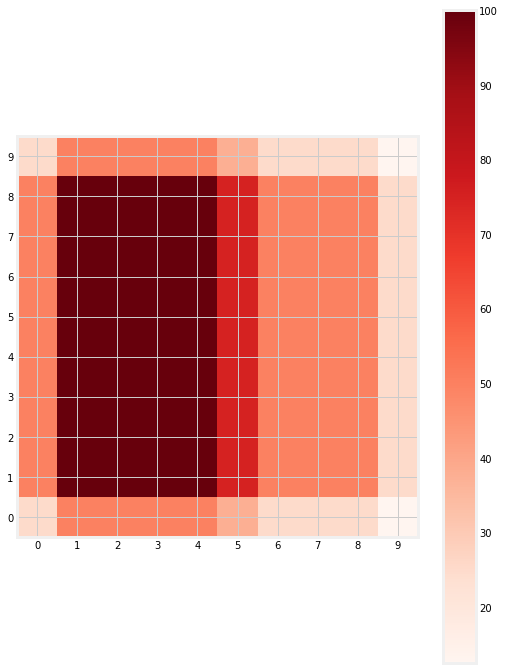

In [340]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (8, 12))
plt.imshow(X = flux_array, cmap='Reds', interpolation='nearest', origin = 'lower')
plt.colorbar()
plt.xticks(np.linspace(0, m-1, m))
plt.yticks(np.linspace(0, n-1, n))
plt.show()